<a href="https://colab.research.google.com/github/zilver666/229352-StatisticalLearning-Lab/blob/main/229351_LAB09_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### ปฏิบัติการครั้งที่ 9

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน  
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 2 ปีสุดท้ายและ Training set เป็นข้อมูลที่เหลือ  
3. ลองสร้างโมเดล SARIMA อันดับต่างๆ แล้วระบุโมเดลที่ดีที่สุด  
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3


In [25]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [26]:
url = "https://donlapark.pages.dev/229351/data/CM_temp.csv"
df = pd.read_csv(url)

df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").sort_index()
y = df["MaxTemp"].resample("MS").mean().dropna()

y.head()

,MaxTemp
Date,
1998-01-01,31.687097
1998-02-01,33.685714
1998-03-01,37.103226
1998-04-01,37.910000
1998-05-01,35.848387


In [27]:

train = y[: "2017-12-01"]
test  = y["2018-01-01": "2019-12-01"]
(len(train), len(test), train.index.min(), train.index.max(), test.index.min(), test.index.max())


(240,
 19,
 Timestamp('1998-01-01 00:00:00'),
 Timestamp('2017-12-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'))

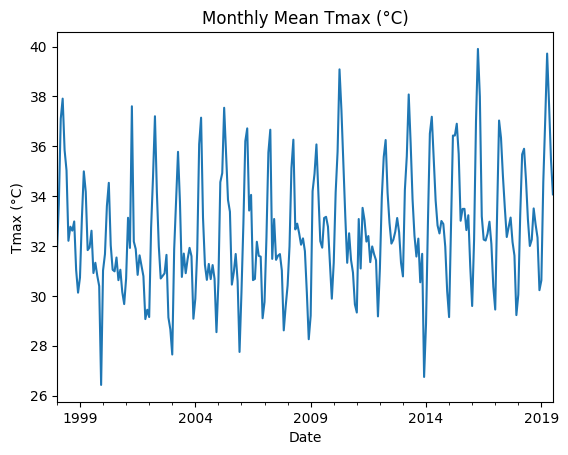

In [28]:

plt.figure()
y.plot(title="Monthly Mean Tmax (°C)")
plt.xlabel("Date")
plt.ylabel("Tmax (°C)")
plt.show()


In [29]:

model1 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
model2 = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)

print("Model1 AIC:", model1.aic)
print("Model2 AIC:", model2.aic)

best_model = model1 if model1.aic < model2.aic else model2
print("Best model:", "Model1" if best_model==model1 else "Model2")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model1 AIC: 710.0839825189248
Model2 AIC: 709.084481736992
Best model: Model2


In [30]:

pred = best_model.get_prediction(start=test.index[0], end=test.index[-1]).predicted_mean.reindex(test.index)
rmse = float(np.sqrt(np.mean((pred.values - test.values)**2)))
print("RMSE:", round(rmse, 4))
pred.head()


RMSE: 1.0217


,predicted_mean
Date,
2018-01-01,30.000921
2018-02-01,33.380644
2018-03-01,36.069444
2018-04-01,37.281469
2018-05-01,35.357962


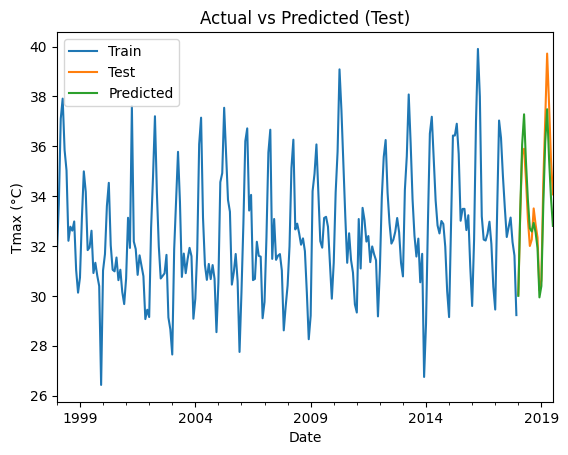

In [31]:

plt.figure()
train.plot(label="Train")
test.plot(label="Test")
pred.plot(label="Predicted")
plt.legend()
plt.title("Actual vs Predicted (Test)")
plt.xlabel("Date")
plt.ylabel("Tmax (°C)")
plt.show()
